# Neural Network Analysis

In [53]:
!pip install jdc
import jdc
import numpy as np
import matplotlib.pyplot as plt
from collections import defaultdict
from pprint import pprint

## Define Class

In [54]:
# activation functions
def sigmoid(x=0, deriv=False):
    sigmoid=1/(1+np.exp(-x))
    if(deriv==True):
        return sigmoid*(1-sigmoid)
    return sigmoid

def sin(x=0, deriv=False):
    if(deriv==True):
        return np.cos(x)
    return np.sin(x)

def relu(x=0, deriv=False):
    if(deriv==True):
        return (x > 0).astype(int)
    return x * (x > 0).astype(int)

In [55]:
class neural_net:    
    def __init__(self):
        # inputs
        self.nodes_tracker = defaultdict() # tracks {layer_num: num_nodes}
        self.act_tracker = defaultdict() # tracks {layer_num: activation_function}
        self.lr_tracker = defaultdict() # tracks {layer_num: gamma/learning_rate}  
        self.weights = defaultdict() # tracks weights from previous layer to next {prev_layer: weights to next layer}              
        
        # training
        self.feed_fwd_tracker = defaultdict() # tracks feed forward {layer_num:feed_forward values}
        self.delta_tracker = defaultdict() # tracks delta for weight updates {layer_num:delta values}        
        
        # others
        self.layer_num = 0 # +1 for every hidden layer added
        self.act_func_list = {'relu':relu, 'sin':sin, 'sigmoid':sigmoid} # activation functions
        self.errors = []

In [56]:
%%add_to neural_net
def add_input_layer(self, num_inputs):
    self.nodes_tracker[f'layer_{self.layer_num}'] = num_inputs
    self.layer_num += 1 # for next hidden layer    

def add_layer(self, num_nodes, activation='relu', learning_rate=0.01):    
    self.nodes_tracker[f'layer_{self.layer_num}'] = num_nodes
    self.act_tracker[f'layer_{self.layer_num}'] = self.act_func_list[activation]    
    self.lr_tracker[f'layer_{self.layer_num}'] = learning_rate
    self.layer_num += 1 # for next hidden layer    

In [57]:
%%add_to neural_net
# can implement xavier-glorot later
def init_weights(self):    
    '''initialize weights'''
    
    self.num_layers = len(self.nodes_tracker.keys())    
    for i in range(self.num_layers-1):
        np.random.seed(i)
        prev_layer = f'layer_{i}'
        next_layer = f'layer_{i+1}'
        self.weights[prev_layer] = 2*np.random.random((self.nodes_tracker[prev_layer],self.nodes_tracker[next_layer])) - 1
        
#     print('weights')
#     pprint(self.weights)
    

In [58]:
%%add_to neural_net
def feed_forward(self):
    # Feed forward through layers 0, 1, and 2    
    # initialize with training data

#     layer0 = X
#     layer1 = nonlin(np.dot(layer0,w0))
#     layer2 = nonlin(np.dot(layer1,w1))
#     layer3 = nonlin(np.dot(layer2,w2))    
    
    self.feed_fwd_tracker['layer_0'] = self.X_train # input from fit function
    
    for i in range(0, self.num_layers-1):
        prev_layer = f'layer_{i}'
        next_layer = f'layer_{i+1}'       
        
        prev_next_vals = np.dot(self.feed_fwd_tracker[prev_layer], self.weights[prev_layer])        
        self.feed_fwd_tracker[next_layer] = self.act_tracker[next_layer](prev_next_vals)
    
#     pprint(self.feed_fwd_tracker)
    

In [59]:
%%add_to neural_net
def backprop(self):
    
    # get delta from last layer
    # layer3_delta = layer3_error*nonlin(np.dot(layer2,w2),deriv=True)
    last_layer_name = f'layer_{self.layer_num-1}' # e.g. 4th layer is layer_3
    prev_layer_name = f'layer_{self.layer_num-2}' # e.g. 3rd layer is layer_2
    
    last_layer_ff = self.feed_fwd_tracker[last_layer_name] 
    prev_layer_ff = self.feed_fwd_tracker[prev_layer_name]    
    prev_layer_weights = self.weights[prev_layer_name]        

    dot_val = np.dot(prev_layer_ff, prev_layer_weights)    
    self.delta_tracker[last_layer_name] = self.error * self.act_tracker[last_layer_name](dot_val, deriv=True)
    
    # propagate gradients the previous layers
    # layer2_delta = layer3_delta.dot(w2.T)*nonlin(np.dot(layer1,w1),deriv=True)    
    for i in np.arange(self.num_layers-1, 1, -1):
        next_layer_name = f'layer_{i}' # e.g. layer 3     
        current_layer_name = f'layer_{i-1}' # e.g. layer 2
        prev_layer_name = f'layer_{i-2}' # e.g. layer 1
        
        next_layer_ff = self.feed_fwd_tracker[next_layer_name] 
        current_layer_ff = self.feed_fwd_tracker[current_layer_name]    
        current_layer_weights = self.weights[current_layer_name]
        
        prev_layer_ff = self.feed_fwd_tracker[prev_layer_name]    
        prev_layer_weights = self.weights[prev_layer_name]        
                
        part_a = self.delta_tracker[next_layer_name].dot(current_layer_weights.T)
        part_b = np.dot(prev_layer_ff, prev_layer_weights)    
        part_c = self.act_tracker[current_layer_name](part_b, deriv=True)
        self.delta_tracker[current_layer_name] = part_a * part_c
        
    # update weights
    # w2 += gamma2*layer2.T.dot(layer3_delta)
    for i in range(self.layer_num-1):
        
        # we want to update weights from next layer to next {prev_layer: weight to next}
        
        next_layer_name = f'layer_{i+1}' # e.g. layer 3     
        current_layer_name = f'layer_{i}' # e.g. layer 2
        
        gamma = self.lr_tracker[next_layer_name] # learning rate to next layer
        current_layer_ff = self.feed_fwd_tracker[current_layer_name] # feed forward value  
        next_layer_delta = self.delta_tracker[next_layer_name] # delta from next layer
        
        self.weights[current_layer_name] += gamma * current_layer_ff.T.dot(next_layer_delta)
        
#         print(current_layer_name, 'to', next_layer_name)        
#         print(gamma * current_layer_ff.T.dot(next_layer_delta))
        
    
#     w2 += gamma2*layer2.T.dot(layer3_delta)
#     w1 += gamma1*layer1.T.dot(layer2_delta)
#     w0 += gamma0*layer0.T.dot(layer1_delta)    

#     pprint(self.delta_tracker)
#     pprint(self.weights)

In [73]:
%%add_to neural_net
def fit(self, X_train, y_train, train_iter, verbose=False):
    self.X_train = X_train
    self.y_train = y_train 
    
    # last_layer name
    self.last_layer = f'layer_{len(self.nodes_tracker.keys())-1}'
    print('last layer', self.last_layer)
    
    # initialize weights
    self.init_weights()
#     print('weights initialized')
#     print(f'starting training {train_iter} iterations')
    for i in range(train_iter):
        # feed forward
        self.feed_forward()
        
        # Error Function
        self.error = self.y_train - self.feed_fwd_tracker[self.last_layer]
        error_mean = np.mean(np.abs(self.error))
        self.errors.append(error_mean)
        if verbose:
            if (i%train_iter//10) == 0:
                print ("Error =", error_mean)  
                
        # backprop
        self.backprop()
    

## Train

### Example 1 layer

In [74]:
X_train = np.array([[1,-1,-1],
                    [1,-1,1],
                    [1, 1,-1],
                    [1, 1,1] ])

y_train = np.array([[0,0,0,1],[0,1,1,1],[0,1,1,0],[1,0,0,1]]).T

last layer layer_2


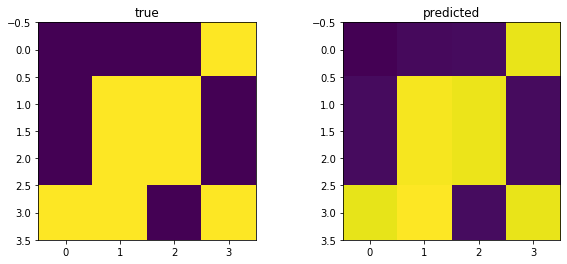

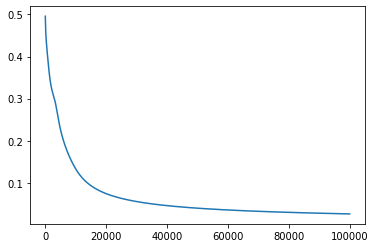

In [75]:
nn = neural_net()
nn.add_input_layer(3) # input layer
nn.add_layer(3, activation='sigmoid', learning_rate=0.1)
nn.add_layer(4, activation='sigmoid', learning_rate=0.01) # output layer

np.random.seed(42)
nn.fit(X_train, y_train, train_iter=100000, verbose=False)

# final output
f, axs = plt.subplots(1, 2, figsize=(10, 4))
axs[0].imshow(y_train)
axs[0].set_title('true')
axs[1].imshow(nn.feed_fwd_tracker['layer_2'])
axs[1].set_title('predicted')
plt.show()

# errors
plt.plot(nn.errors)
plt.show()

### Example 2 layers

last layer layer_3


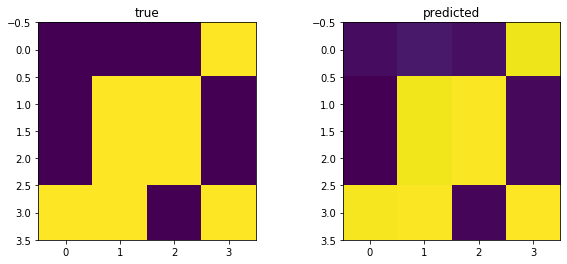

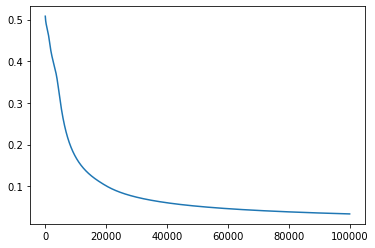

In [76]:
nn = neural_net()
nn.add_input_layer(3) # input layer
nn.add_layer(3, activation='sigmoid', learning_rate=0.1)
nn.add_layer(3, activation='sigmoid', learning_rate=0.1)
nn.add_layer(4, activation='sigmoid', learning_rate=0.01) # output layer

np.random.seed(42)
nn.fit(X_train, y_train, train_iter=100000, verbose=False)

# final output
f, axs = plt.subplots(1, 2, figsize=(10, 4))
axs[0].imshow(y_train)
axs[0].set_title('true')
axs[1].imshow(nn.feed_fwd_tracker['layer_3'])
axs[1].set_title('predicted')
plt.show()

# errors
plt.plot(nn.errors)
plt.show()

## Testing different parameters

In [77]:
X_train = np.array([[1,-1,-1],
                    [1,-1,1],
                    [1, 1,-1],
                    [1, 1,1] ])

y_train = np.array([[0,0,0,1],[0,1,1,1],[0,1,1,0],[1,0,0,1]]).T

In [78]:
import itertools as it
import pandas as pd
import matplotlib.pyplot as plt

#create df of possible combinations of nodes
nodes = [3,5,7,9]
df_combs = pd.DataFrame()
for num_hid_layer in [1, 2]:
    df_layer_node = pd.DataFrame()
    for i in range(1,num_hid_layer+1, 1):
        num_nodes = list(it.combinations(nodes, i))
        if i<2:
            num_nodes = list(it.chain(*num_nodes))    
    df_layer_node['num_nodes'] = num_nodes
    df_layer_node['num_hid_layer'] = num_hid_layer
        
    df_combs = pd.concat([df_combs, df_layer_node])
df_combs

,num_nodes,num_hid_layer
0,3,1
1,5,1
2,7,1
3,9,1
0,"(3, 5)",2
1,"(3, 7)",2
2,"(3, 9)",2
3,"(5, 7)",2
4,"(5, 9)",2
5,"(7, 9)",2


last layer layer_2
last layer layer_2
last layer layer_2
last layer layer_2
last layer layer_3
last layer layer_3
last layer layer_3
last layer layer_3
last layer layer_3
last layer layer_3


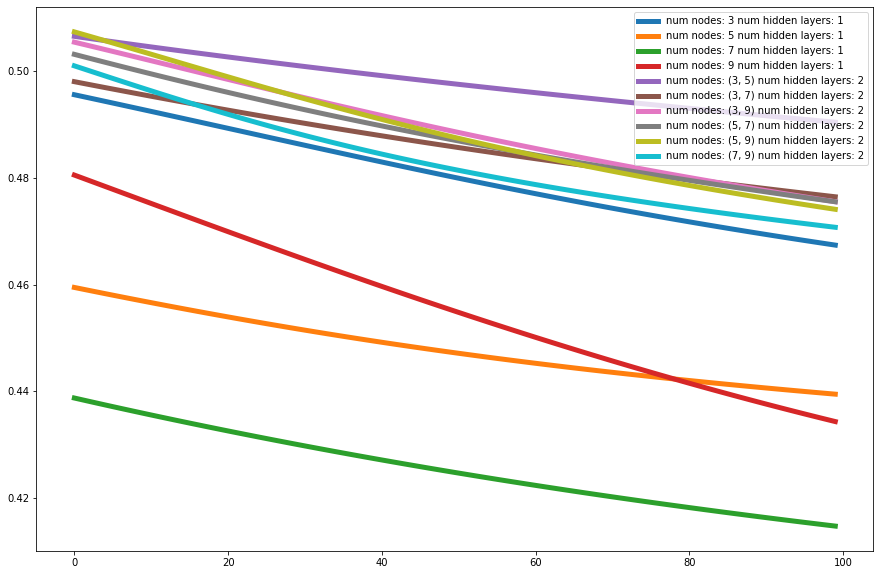

In [79]:
#iterate over df to feed in NN
main_canvas = plt.figure(figsize = (15, 10))
plot_canvas = plt.subplot(1, 1, 1)
# attrib = ["r-", "g-", "b--", "y--", "v--"]

k = 0

for index, row in df_combs.iterrows():
    
    num_hidden = row.values[1]
    num_nodes = np.array([row.values[0]]).flatten()

    nn = neural_net()
    nn.add_input_layer(3) # input
    
    for i in range(num_hidden):
        nn.add_layer(num_nodes=num_nodes[i], activation='sigmoid', learning_rate=0.1)
        
    nn.add_layer(4, activation='sigmoid', learning_rate=0.01) # output

    np.random.seed(42)
    nn.fit(X_train, y_train, train_iter=100, verbose=False)
    
    label = f"num nodes: {df_combs['num_nodes'].iloc[k]} num hidden layers: {df_combs['num_hid_layer'].iloc[k]}"
#     plot_canvas.plot(nn.errors, attrib[k], lw = 5, label=label)
    plot_canvas.plot(nn.errors, lw = 5, label=label)
    k += 1
plt.legend()
plt.show()